# Surface water mass transformation on the shelf

In [37]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import xarray as xr
import os.path
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
from iav_AABW_functions import (
    yearly_mean, mask_from_polygon,shelf_mask_isobath)

import cmocean.cm as cmo
import matplotlib.ticker as mticker

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [38]:
plt.rcParams['figure.dpi'] = 96
plt.rcParams["font.size"] = 12
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["lines.linewidth"] = 1.5
plt.rcParams["lines.markersize"] = 3
plt.rcParams['hatch.color'] = 'k'
plt.rcParams["savefig.facecolor"] = 'white'

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41913,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:37737,Total threads: 4
Dashboard: /proxy/38395/status,Memory: 62.50 GiB
Nanny: tcp://127.0.0.1:46065,


In [34]:
session = cc.database.create_session()

exp_ctrl = '01deg_jra55v140_iaf_cycle4'
exp_melt = '01deg_jra55v140_iaf_cycle4_MWpert'

start_time = '1979-01-01'
end_time = '2018-12-31'
frequency = '1 monthly'

lat_slice = slice(-80, -59)

path_output = '/g/data/e14/cs6673/meltwater/data_SWMT/'

In [31]:
DSW_region = {
    'name': ['Weddell', 'Prydz', 'Adelie', 'Ross'],
    'name_long': ['Weddell Sea', 'Prydz Bay', 'Adélie Coast', 'Ross Sea'],
    'lon': [[-60, -35, -48, -62, -60],
            [48, 73, 74, 48, 48],
            [128-360, 152-360, 152-360, 128-360, 128-360],
            [185-360, 160-360, 164-360, 172-360, 185-360]],
    'lat': [[-71, -75, -78, -75, -71],
            [-65, -66.5, -69, -68, -65],
            [-64.5, -66, -69, -67.5, -64.5],
            [-78, -78, -73, -71.5, -78]]}

## Load data

In [35]:
# topography data for plotting:
ht = cc.querying.getvar(exp_ctrl,'ht' , session,n=1).sel(yt_ocean=lat_slice)
land_mask = (ht*0).fillna(1)
xt_ocean = cc.querying.getvar(
    exp_ctrl, 'xt_ocean', session, frequency='static', n=1)
yt_ocean = cc.querying.getvar(
    exp_ctrl, 'yt_ocean', session, frequency='static', n=1).sel(
    yt_ocean=slice(-90, -60))
# land_mask = np.squeeze(ht.values)*0
# land_mask[np.isnan(land_mask)] = 1
# land_mask = np.where(land_mask==1,land_mask,np.nan)
# land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# # make land go all the way to -90S:
# land_mask_lat = ht.yt_ocean.values
# land_mask_lat[0] = -90

In [39]:
for a, area_text in enumerate(DSW_region['name']):
    if a == 0:
        mask_DSW = mask_from_polygon(
            DSW_region['lon'][a], DSW_region['lat'][a], xt_ocean, yt_ocean).expand_dims(
            area=['Weddell'])
    else:
        mask_DSW = xr.concat((mask_DSW, mask_from_polygon(
            DSW_region['lon'][a], DSW_region['lat'][a],
            xt_ocean, yt_ocean).expand_dims(area=[area_text])), dim='area')
    mask_DSW, shelf_mask = shelf_mask_isobath(mask_DSW, output_mask=True)
mask_DSW = mask_DSW.where(mask_DSW == True)
mask_DSW = mask_DSW.where(land_mask == 0)
mask_DSW = mask_DSW .where(mask_DSW == 1, 0)

In [6]:
# SWMT for all density classes at each grid point
ds_SWMT = xr.open_mfdataset(
    path_output + 'SWMT_for_sig0_27-2_28-1_' +
    exp_melt + '_' + frequency[0:3:2] + '_*.nc',
    chunks={'xt_ocean': '500MB', 'yt_ocean': '500MB'})
ds_SWMT['isopycnal_bins'] = ds_SWMT.isopycnal_bins - .5*(
    ds_SWMT.isopycnal_bins[1]-ds_SWMT.isopycnal_bins[0])  # upper boundary of sig0 bin
# select only one denisty class and calcualate temporal mean to plot map of SWMT
ds_SWMT_Tmean = yearly_mean(ds_SWMT.sel(
    isopycnal_bins=27.85, method='nearest')).compute()
SWMT_Tmean = (ds_SWMT_Tmean.binned_heat_transformation +
              ds_SWMT_Tmean.binned_salt_transformation).mean('time')
SWMT_Tmean, shelf_mask = shelf_mask_isobath(SWMT_Tmean, output_mask=True)
SWMT_Tmean = SWMT_Tmean.where(SWMT_Tmean != 0)

#last decade
SWMT_Tmean_last10y = (ds_SWMT_Tmean.binned_heat_transformation +
              ds_SWMT_Tmean.binned_salt_transformation).sel(
    time=slice(2009, 2018)).mean('time')
SWMT_Tmean_last10y = shelf_mask_isobath(SWMT_Tmean_last10y)
SWMT_Tmean_last10y = SWMT_Tmean_last10y.where(SWMT_Tmean_last10y != 0)

In [7]:
"""SWMT summed over Antarctic shelf"""
filename = ('SWMT_on_Antarctic_shelf_for_sig0_27-2_28-1_' +
            exp_melt + '_' + frequency[0:3:2] + '_' + start_time[:4] +
            '-' + end_time[:4] + '.nc')
# one file, but same temporal resolution
if os.path.exists(path_output + filename) is False:
    ds_SWMT = xr.open_mfdataset(
        path_output + 'SWMT_on_Antarctic_shelf_for_sig0_27-2_28-1_' +
        exp_melt + '_' + frequency[0:3:2] + '*.nc')
    ds_SWMT.to_netcdf(path_output + filename)
    for year in range(np.int(start_time[:4]), np.int(end_time[:4])+1):
        os.remove(
            path_output + 'SWMT_on_Antarctic_shelf_for_sig0_27-2_28-1_' +
            exp_melt + '_' + frequency[0:3:2] + '_' + str(year) + '.nc')

ds_SWMT_shelf = xr.open_mfdataset(path_output + filename)
ds_SWMT_shelf = yearly_mean(ds_SWMT_shelf).compute()

SWMT_heat_shelf = ds_SWMT_shelf.binned_heat_transformation
SWMT_salt_shelf = ds_SWMT_shelf.binned_salt_transformation
SWMT_shelf = SWMT_heat_shelf + SWMT_salt_shelf

In [8]:
"""SWMT summed over Antarctic shelf in control run"""
filename = ('SWMT_on_Antarctic_shelf_for_sig0_27-2_28-1_' +
            exp_ctrl + '_' + frequency[0:3:2] + '_' + start_time[:4] +
            '-' + end_time[:4] + '.nc')

# one file, but same temporal resolution
if os.path.exists(path_output + filename) is False:
    ds_SWMT = xr.open_mfdataset(
        path_output + 'SWMT_on_Antarctic_shelf_for_sig0_27-2_28-1_' +
        exp_ctrl + '_' + frequency[0:3:2] + '*.nc')
    ds_SWMT.to_netcdf(path_output + filename)
    for year in range(np.int(start_time[:4]), np.int(end_time[:4])+1):
        os.remove(
            path_output + 'SWMT_on_Antarctic_shelf_for_sig0_27-2_28-1_' +
            exp_ctrl + '_' + frequency[0:3:2] + '_' + str(year) + '.nc')
ds_SWMT_ctrl_shelf = xr.open_mfdataset(path_output + filename)
ds_SWMT_ctrl_shelf = yearly_mean(ds_SWMT_ctrl_shelf).compute()

SWMT_ctrl_heat_shelf = ds_SWMT_ctrl_shelf.binned_heat_transformation
SWMT_ctrl_salt_shelf = ds_SWMT_ctrl_shelf.binned_salt_transformation
SWMT_ctrl_shelf = SWMT_ctrl_heat_shelf + SWMT_ctrl_salt_shelf

In [9]:
"""SWMT summed in DSW formation regions"""
filename = ('SWMT_in_AABW_formation_region_for_sig0_27-2_28-1_' +
            exp_melt + '_' + frequency[0:3:2] + '_' + start_time[:4] +
            '-' + end_time[:4] + '.nc')
# one file, but same temporal resolution
if os.path.exists(path_output + filename) is False:
    ds_SWMT = xr.open_mfdataset(
        path_output + 'SWMT_in_AABW_formation_region_for_sig0_27-2_28-1_' +
        exp_melt + '_' + frequency[0:3:2] + '*.nc')
    ds_SWMT.to_netcdf(path_output + filename)
    for year in range(np.int(start_time[:4]), np.int(end_time[:4])+1):
        os.remove(
            path_output + 'SWMT_in_AABW_formation_region_for_sig0_27-2_28-1_' +
            exp_melt + '_' + frequency[0:3:2] + '_' + str(year) + '.nc')

ds_SWMT_DSW = xr.open_mfdataset(path_output + filename)
ds_SWMT_DSW = yearly_mean(ds_SWMT_DSW).compute()

SWMT_heat_DSW = ds_SWMT_DSW.binned_heat_transformation_in_AABW_region
SWMT_salt_DSW = ds_SWMT_DSW.binned_salt_transformation_in_AABW_region
SWMT_DSW = SWMT_heat_DSW + SWMT_salt_DSW

In [10]:
"""SWMT summed in DSW formation regions in control run"""
filename = ('SWMT_in_AABW_formation_region_for_sig0_27-2_28-1_' +
            exp_ctrl + '_' + frequency[0:3:2] + '_' + start_time[:4] +
            '-' + end_time[:4] + '.nc')
# one file, but same temporal resolution
if os.path.exists(path_output + filename) is False:
    ds_SWMT = xr.open_mfdataset(
        path_output + 'SWMT_in_AABW_formation_region_for_sig0_27-2_28-1_' +
        exp_ctrl + '_' + frequency[0:3:2] + '*.nc')
    ds_SWMT.to_netcdf(path_output + filename)
    for year in range(np.int(start_time[:4]), np.int(end_time[:4])+1):
        os.remove(
            path_output + 'SWMT_in_AABW_formation_region_for_sig0_27-2_28-1_' +
            exp_ctrl + '_' + frequency[0:3:2] + '_' + str(year) + '.nc')

ds_SWMT_ctrl_DSW = xr.open_mfdataset(path_output + filename)
ds_SWMT_ctrl_DSW = yearly_mean(ds_SWMT_ctrl_DSW).compute()

SWMT_ctrl_heat_DSW = ds_SWMT_ctrl_DSW.binned_heat_transformation_in_AABW_region
SWMT_ctrl_salt_DSW = ds_SWMT_ctrl_DSW.binned_salt_transformation_in_AABW_region
SWMT_ctrl_DSW = SWMT_ctrl_heat_DSW + SWMT_ctrl_salt_DSW

### Timeseries of SWMT

density bin is where the mean SWMT is 70% below its peak value

In [89]:
for a in range(4):
    if a == 0:
        SWMT_DSW_max = SWMT_DSW.mean('time')[SWMT_DSW.mean('time')[:, a].argmax(
            'isopycnal_bins').values, a]
        SWMT_DSW_sig0_bin = SWMT_DSW.isopycnal_bins.sel(
            isopycnal_bins=slice(SWMT_DSW_max.isopycnal_bins, None)).where(
            SWMT_DSW.mean('time')[:, a] < SWMT_DSW_max*.7).min('isopycnal_bins')
    else:
        SWMT_DSW_max = xr.concat((SWMT_DSW_max, SWMT_DSW.mean('time')[SWMT_DSW.mean('time')[:, a].argmax(
            'isopycnal_bins').values, a]), dim='area')
        SWMT_DSW_sig0_bin = xr.concat((SWMT_DSW_sig0_bin, SWMT_DSW.isopycnal_bins.sel(
            isopycnal_bins=slice(SWMT_DSW_max[a].isopycnal_bins, None)).where(
            SWMT_DSW.mean('time')[:, a] < SWMT_DSW_max[a]*.7).min('isopycnal_bins')), dim='area')

In [116]:
SWMT_DSW_yr = SWMT_DSW.sel(
    isopycnal_bins=SWMT_DSW_sig0_bin.rename({'area': 'AREA'}).drop('AREA'),
    area=xr.DataArray(DSW_region['name'], dims='AREA'),
    method='nearest').rename({'AREA': 'area'}).assign_coords(area=SWMT_DSW.area).transpose()
SWMT_ctrl_DSW_yr = SWMT_ctrl_DSW.sel(
    isopycnal_bins=SWMT_DSW_sig0_bin.rename({'area': 'AREA'}).drop('AREA'),
    area=xr.DataArray(DSW_region['name'], dims='AREA'),
    method='nearest').rename({'AREA': 'area'}).assign_coords(area=SWMT_DSW.area).transpose()

## Plots

In [11]:
# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

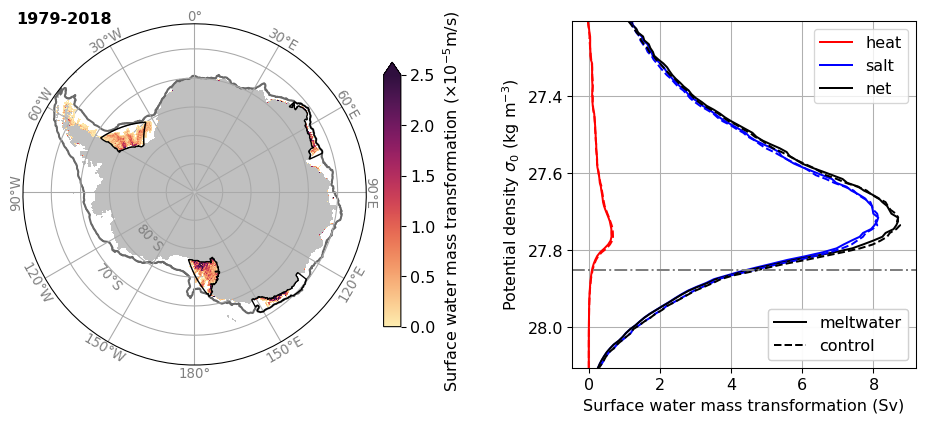

In [40]:
fig = plt.figure(figsize=(12, 10))
plt.subplots_adjust(wspace=.6)

proj = ccrs.PlateCarree()

ax = plt.subplot(1, 2, 1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
ax.set_boundary(circle, transform=ax.transAxes)

gl = ax.gridlines(draw_labels=False, color='darkgray')
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 30))
label_lon = ['0°', '180°', '60°E', '120°W', '120°E', '60°W',
             '90°E', '90°W', '30°E', '150°W', '150°E', '30°W']
rot_lon = [0, 0, -60, -60, 60, 60, -90, 90, -30, -30, 30, 30]
lat_lon_label = [-59.5, -58.7, -59.5, -58.5, -58.5, -59.2, -59.5, -59.2,
                 -59.5, -58.7, -58.7, -59.5]
for i, position in enumerate([0, 180, 60, -120, 120, -60, 90, -90,
                              30, -150, 150, -30]):
    ax.text(position, lat_lon_label[i], label_lon[i], rotation=rot_lon[i],
            horizontalalignment='center', verticalalignment='center',
            color='gray', fontsize=10, transform=ccrs.PlateCarree())
for j in range(70, 90, 10):
    label = str(j) + '°S'
    ax.text(-135, -j+1.3, label, rotation=-48, horizontalalignment='center',
            verticalalignment='center', color='gray', fontsize=10,
            transform=ccrs.PlateCarree())

ax.contourf(land_mask.xt_ocean.values,
            np.concatenate(([-90], land_mask.yt_ocean[1:].values)),
            land_mask, colors='silver', levels=[0.5, 2],
            transform=proj, rasterized=True, zorder=2)
p = ax.pcolormesh(SWMT_Tmean.xt_ocean, SWMT_Tmean.yt_ocean,
                  SWMT_Tmean*1e5, vmin=0, vmax=2.5,
                  cmap=cmo.matter, transform=ccrs.PlateCarree(),
                  rasterized=True, zorder=3)
plt.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean, shelf_mask.values,
            levels=[0, 1], colors = 'dimgray', linewidth=.7,
            transform=ccrs.PlateCarree())
for a, area_text in enumerate(DSW_region['name']):
    plt.contour(mask_DSW.xt_ocean, mask_DSW.yt_ocean, mask_DSW[a, :, :], levels=[1],
                colors='k', linewidths=1, transform=proj, zorder=5)
plt.text(-.02, 1, '1979-2018', fontweight='bold', transform=ax.transAxes)

padx, pady, width = (0.015, .04, 0.015)
pos = ax.get_position()
cax = plt.axes([pos.xmax+padx, pos.ymin+pady, width, (pos.ymax-pos.ymin)-2*pady])
cb = plt.colorbar(p, cax=cax, orientation='vertical', extend='max')
cb.ax.set_ylabel(r'Surface water mass transformation ($\times 10^{-5}$m/s)')

plt.subplot(4, 2, (4, 6))
plt.plot(
    SWMT_heat_shelf.mean('time'), SWMT_heat_shelf.isopycnal_bins,
    color='r', label='heat')
plt.plot(
    SWMT_salt_shelf.mean('time'), SWMT_salt_shelf.isopycnal_bins,
    color='b', label='salt')
plt.plot(
    SWMT_shelf.mean('time'), SWMT_shelf.isopycnal_bins,
    color='k', label='net')
# ctrl
plt.plot(
    SWMT_ctrl_heat_shelf.mean('time'), SWMT_ctrl_heat_shelf.isopycnal_bins,
    color='r', linestyle='--')
plt.plot(
    SWMT_ctrl_salt_shelf.mean('time'), SWMT_ctrl_salt_shelf.isopycnal_bins,
    color='b', linestyle='--')
plt.plot(
    SWMT_ctrl_shelf.mean('time'), SWMT_ctrl_shelf.isopycnal_bins,
    color='k', linestyle='--')
plt.axhline(27.85, color='grey', linestyle='-.')

lines = plt.gca().get_lines()
legend1 = plt.legend(
    [lines[i] for i in [0,1,2]],
    [lines[i].get_label() for i in [0, 1, 2]], loc=1)
legend2 = plt.legend(
    [lines[i] for i in [2, 5]], ['meltwater', 'control'], loc=4)
plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)

plt.gca().invert_yaxis()
plt.autoscale(enable=True, axis='y', tight=True)
plt.grid()

plt.xlabel('Surface water mass transformation (Sv)')
plt.ylabel('Potential density $\sigma_0$ (kg m$^{-3}$)')

plt.show()

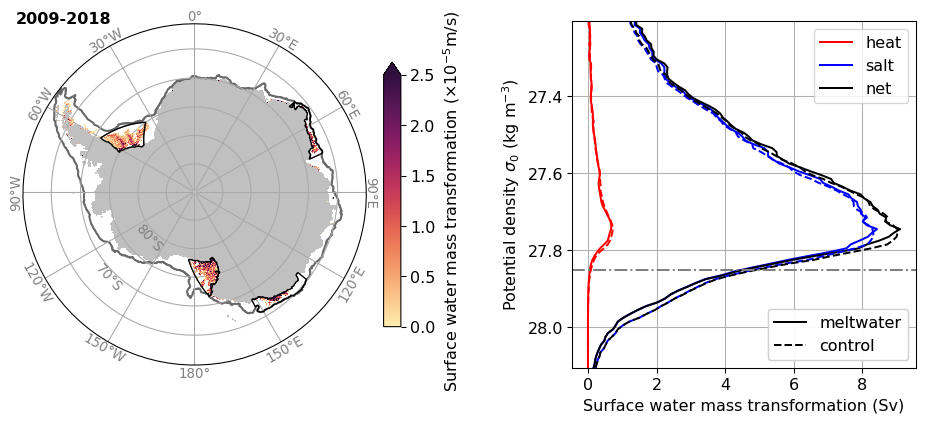

In [41]:
fig = plt.figure(figsize=(12, 10))
plt.subplots_adjust(wspace=.6)

proj = ccrs.PlateCarree()

ax = plt.subplot(1, 2, 1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
ax.set_boundary(circle, transform=ax.transAxes)

gl = ax.gridlines(draw_labels=False, color='darkgray')
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 30))
label_lon = ['0°', '180°', '60°E', '120°W', '120°E', '60°W',
             '90°E', '90°W', '30°E', '150°W', '150°E', '30°W']
rot_lon = [0, 0, -60, -60, 60, 60, -90, 90, -30, -30, 30, 30]
lat_lon_label = [-59.5, -58.7, -59.5, -58.5, -58.5, -59.2, -59.5, -59.2,
                 -59.5, -58.7, -58.7, -59.5]
for i, position in enumerate([0, 180, 60, -120, 120, -60, 90, -90,
                              30, -150, 150, -30]):
    ax.text(position, lat_lon_label[i], label_lon[i], rotation=rot_lon[i],
            horizontalalignment='center', verticalalignment='center',
            color='gray', fontsize=10, transform=ccrs.PlateCarree())
for j in range(70, 90, 10):
    label = str(j) + '°S'
    ax.text(-135, -j+1.3, label, rotation=-48, horizontalalignment='center',
            verticalalignment='center', color='gray', fontsize=10,
            transform=ccrs.PlateCarree())

ax.contourf(land_mask.xt_ocean.values,
            np.concatenate(([-90], land_mask.yt_ocean[1:].values)),
            land_mask, colors='silver', levels=[0.5, 2],
            transform=proj, rasterized=True, zorder=2)
p = ax.pcolormesh(SWMT_Tmean.xt_ocean, SWMT_Tmean.yt_ocean,
                  SWMT_Tmean_last10y*1e5, vmin=0, vmax=2.5,
                  cmap=cmo.matter, transform=ccrs.PlateCarree(),
                  rasterized=True, zorder=3)
plt.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean, shelf_mask.values,
            levels=[0, 1], colors = 'dimgray', linewidth=.7,
            transform=ccrs.PlateCarree())
for a, area_text in enumerate(DSW_region['name']):
    plt.contour(mask_DSW.xt_ocean, mask_DSW.yt_ocean, mask_DSW[a, :, :], levels=[1],
                colors='k', linewidths=1, transform=proj, zorder=5)
plt.text(-.02, 1, '2009-2018', fontweight='bold', transform=ax.transAxes)

padx, pady, width = (0.015, .04, 0.015)
pos = ax.get_position()
cax = plt.axes([pos.xmax+padx, pos.ymin+pady, width, (pos.ymax-pos.ymin)-2*pady])
cb = plt.colorbar(p, cax=cax, orientation='vertical', extend='max')
cb.ax.set_ylabel(r'Surface water mass transformation ($\times 10^{-5}$m/s)')

plt.subplot(4, 2, (4, 6))
plt.plot(
    SWMT_heat_shelf.sel(time=slice(2009, 2018)).mean('time'),
    SWMT_heat_shelf.isopycnal_bins,
    color='r', label='heat')
plt.plot(
    SWMT_salt_shelf.sel(time=slice(2009, 2018)).mean('time'),
    SWMT_salt_shelf.isopycnal_bins,
    color='b', label='salt')
plt.plot(
    SWMT_shelf.sel(time=slice(2009, 2018)).mean('time'),
    SWMT_shelf.isopycnal_bins,
    color='k', label='net')
# ctrl
plt.plot(
    SWMT_ctrl_heat_shelf.sel(time=slice(2009, 2018)).mean('time'),
    SWMT_ctrl_heat_shelf.isopycnal_bins,
    color='r', linestyle='--')
plt.plot(
    SWMT_ctrl_salt_shelf.sel(time=slice(2009, 2018)).mean('time'),
    SWMT_ctrl_salt_shelf.isopycnal_bins,
    color='b', linestyle='--')
plt.plot(
    SWMT_ctrl_shelf.sel(time=slice(2009, 2018)).mean('time'),
    SWMT_ctrl_shelf.isopycnal_bins,
    color='k', linestyle='--')
plt.axhline(27.85, color='grey', linestyle='-.')

lines = plt.gca().get_lines()
legend1 = plt.legend(
    [lines[i] for i in [0,1,2]],
    [lines[i].get_label() for i in [0, 1, 2]], loc=1)
legend2 = plt.legend(
    [lines[i] for i in [2, 5]], ['meltwater', 'control'], loc=4)
plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)

plt.gca().invert_yaxis()
plt.autoscale(enable=True, axis='y', tight=True)
plt.grid()

plt.xlabel('Surface water mass transformation (Sv)')
plt.ylabel('Potential density $\sigma_0$ (kg m$^{-3}$)')

plt.show()

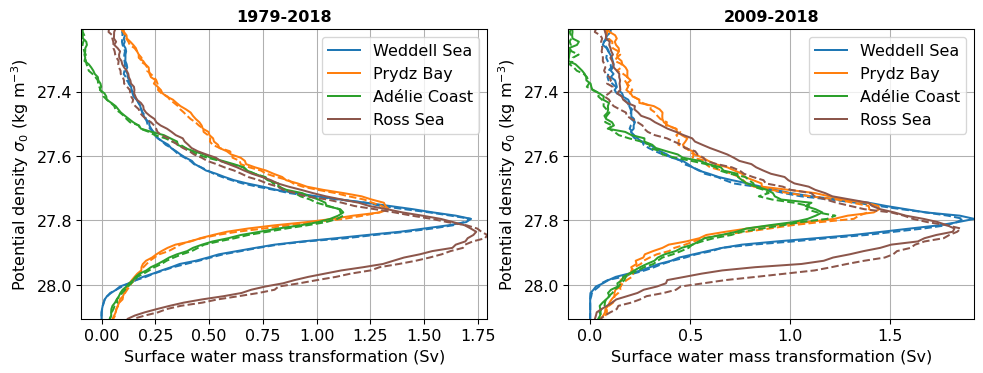

In [30]:
plt.figure(figsize=(12, 4))
col = ['tab:blue', 'tab:orange', 'tab:green', 'tab:brown']
plt.subplot(1, 2, 1)
for a, area_text in enumerate(DSW_region['name']):
    plt.plot(
        SWMT_DSW.sel(area=area_text).mean('time'), SWMT_DSW.isopycnal_bins,
        color=col[a], label=DSW_region['name_long'][a])
    plt.plot(
        SWMT_ctrl_DSW.sel(area=area_text).mean('time'), SWMT_ctrl_DSW.isopycnal_bins,
        color=col[a], linestyle='--')
plt.gca().invert_yaxis()
plt.autoscale(enable=True, axis='both', tight=True)
plt.grid()
plt.legend()

plt.xlabel('Surface water mass transformation (Sv)')
plt.ylabel('Potential density $\sigma_0$ (kg m$^{-3}$)')
plt.title('1979-2018', fontweight='bold')

plt.subplot(1, 2, 2)
for a, area_text in enumerate(DSW_region['name']):
    plt.plot(
        SWMT_DSW.sel(area=area_text, time=slice(2009, 2018)).mean('time'),
        SWMT_DSW.isopycnal_bins,
        color=col[a], label=DSW_region['name_long'][a])
    plt.plot(
        SWMT_ctrl_DSW.sel(area=area_text, time=slice(2009, 2018)).mean('time'),
        SWMT_ctrl_DSW.isopycnal_bins,
        color=col[a], linestyle='--')
plt.gca().invert_yaxis()
plt.autoscale(enable=True, axis='both', tight=True)
plt.grid()
plt.legend()

plt.xlabel('Surface water mass transformation (Sv)')
plt.ylabel('Potential density $\sigma_0$ (kg m$^{-3}$)')
plt.title('2009-2018', fontweight='bold')


plt.show()

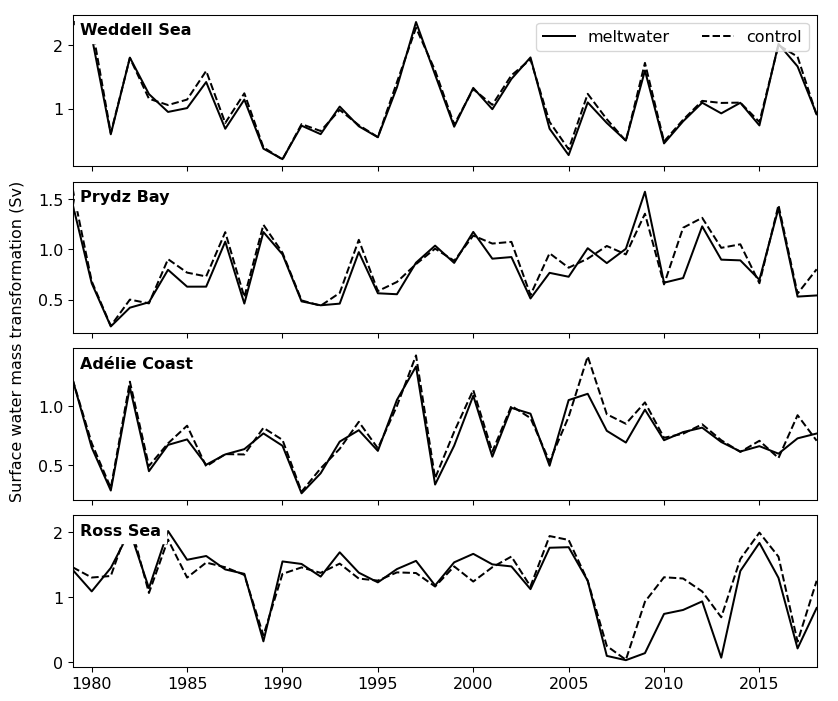

In [120]:
fig = plt.figure(figsize=(10, 9))
plt.subplots_adjust(hspace=0.1)

for a, area_text in enumerate(DSW_region['name']):
    plt.subplot(4, 1, a+1)
    plt.plot(SWMT_DSW_yr.time, SWMT_DSW_yr.sel(area=area_text), color='k',
            label='meltwater')
    plt.plot(SWMT_ctrl_DSW_yr.time, SWMT_ctrl_DSW_yr.sel(area=area_text),
             color='k', linestyle='--', label='control')

    plt.text(0.01, 0.87, DSW_region['name_long'][a],
             fontweight='bold', backgroundcolor='w', transform=plt.gca().transAxes)
    plt.autoscale(enable=True, axis='x', tight=True)
    if a == 0:
        plt.legend(ncol=2, loc='upper right')
    if a < 3:
        plt.gca().set_xticklabels([])

ax = plt.gcf().add_subplot(111, frameon=False)
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False,
               right=False)
ax.set_ylabel('Surface water mass transformation (Sv)', labelpad=10)

plt.show()